In [ ]:
import math
import struct
import inspect
from Config import LMConfig
from typing import Any, Optional, Tuple
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from transformers import PreTrainedModel
from transformers.modeling_outputs import CausalLMOutputWithPast

# CFSLM模型结构

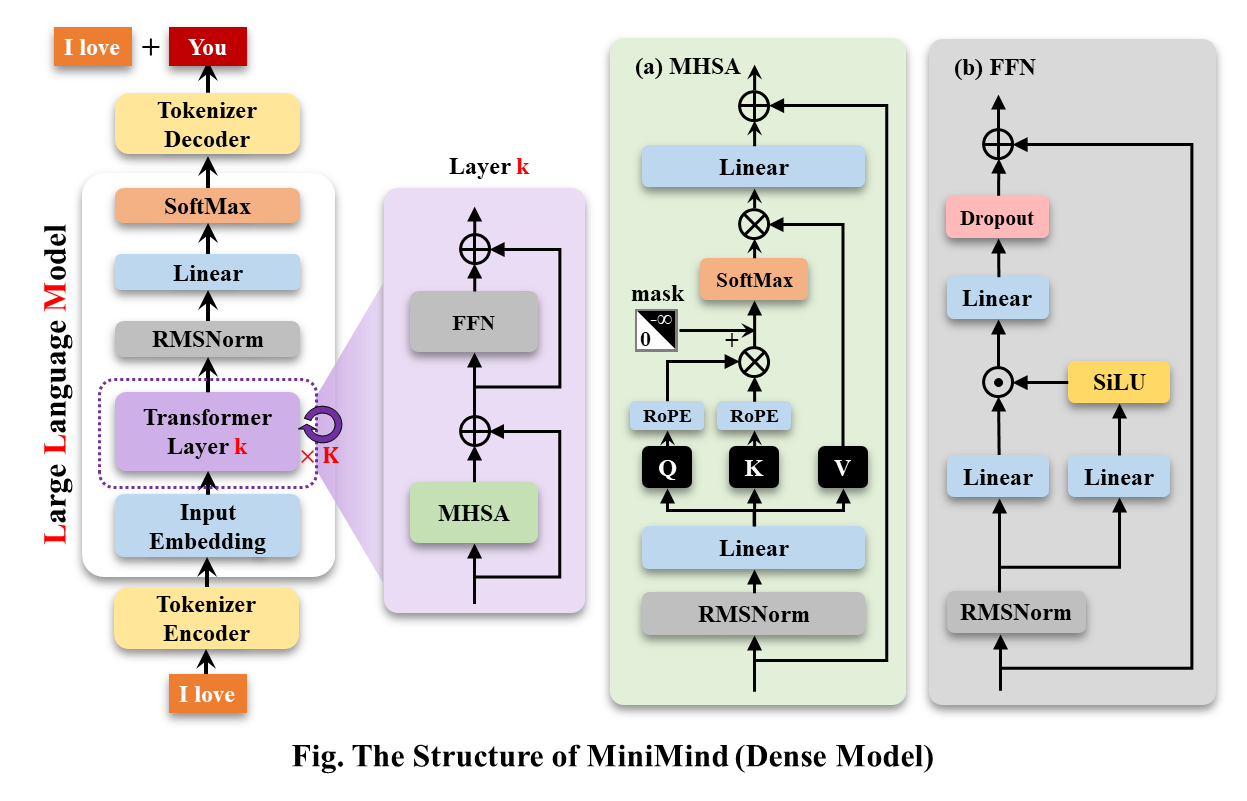
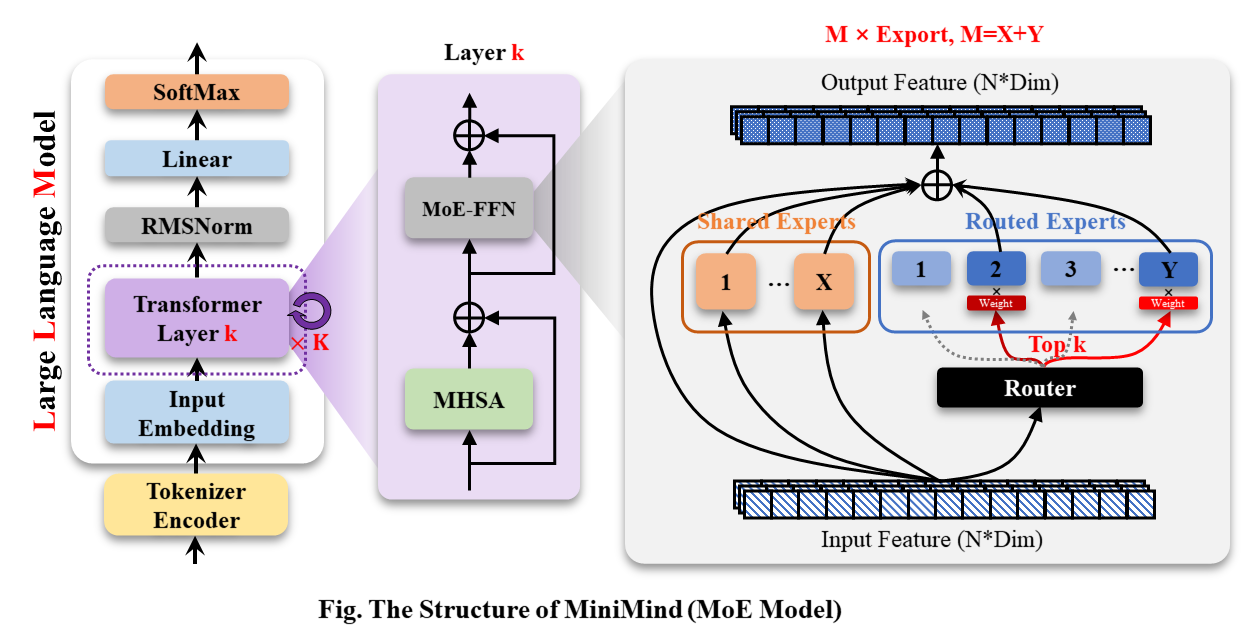

## 定义RMSNorm类

$RMSNorm=\gamma \odot \frac{x}{\sqrt{\frac{1}{d} {\textstyle \sum_{x^i\in x}x^2_i}+\epsilon   } } $

In [ ]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float):
        """
        RMS归一化
        dim: int, 向量维度
        eps: 防止除0错误的小数值
        return: tensor, 归一化结果
        """
        super().__init__()
        self.eps = eps
        # 初始化权重参数
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # RMSNorm公式
        output = (x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)).type_as(x)
        # 乘以权重参数
        return output * self.weight

## RoPE 旋转位置编码

[十分钟读懂RoPE旋转位置编码](https://hub.baai.ac.cn/view/29979)

In [ ]:
def precompute_pos_cis(dim, seq_len, theta= 10000.0):
    """
    生成旋转矩阵
    dim: int, 词向量维度
    seq_len: int, 序列长度
    theta: int,旋转角度的频率范围,默认值10000
            theta 值越大，频率的衰减越慢，意味着生成的旋转角度变化较缓，适合处理长序列。
            theta 值越小，频率的衰减越快，生成的旋转角度变化较快，更适合较短序列。
    return: tensor, 旋转矩阵
    """

    # 频率计算公式，freqs.shape = [seq_len, dim // 2]
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    # 生成 token 序列索引 t = [0, 1,..., seq_len-1]
    t = torch.arange(seq_len, device=freqs.device) 
    # 计算外积
    freqs = torch.outer(t, freqs).float()
    # 生成复数表示的旋转矩阵
    # freqs = [x, y] --> freqs_cis = [cos(x) + sin(x)i, cos(y) + sin(y)i]
    pos_cis = torch.polar(torch.ones_like(freqs), freqs)
    return pos_cis

def apply_rotary_emb(xq, xk, pos_cis):
    """
    为xq,xk应用旋转位置编码
    xq: tensor, q矩阵
    xk: tensor, k矩阵
    pos_cis: tensor, 旋转矩阵
    return: tensor, xq、xq的位置嵌入结果
    """
    def unite_shape(pos_cis, x):
        """
        调整pos_cis为与x兼容的形状
        return: tensor,与x形状兼容的旋转矩阵
        """
        # x的维度数
        ndim = x.ndim
        assert 1 < ndim # 确保x至少是一个二维张量
        assert pos_cis.shape == (x.shape[1], x.shape[-1])
        # 保留x第1维和第ndim - 1维的维度，其他设置为1
        shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
        return pos_cis.view(*shape)
    # xq.shape = [batch_size, seq_len, dim]
    # xq_.shape = [batch_size, seq_len, dim // 2, 2]
    # 将 xq、xk转换为复数形式
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))  
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))  # 将 xk 转换为复数形式
    # 调整 pos_cis 的形状
    pos_cis = unite_shape(pos_cis, xq_)  
    # 应用旋转操作，然后将结果转回实数域
    # xq_out.shape = [batch_size, seq_len, dim]
    xq_out = torch.view_as_real(xq_ * pos_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * pos_cis).flatten(3) 
    return xq_out.type_as(xq), xk_out.type_as(xk)  # 返回结果

## Multi-head 共享

In [ ]:
def repeat_kv(x, n_rep):
    """
    复用 KV 头的值
    x: tensor,k、v矩阵
    n_rep: int, 复用倍数
    return: tensor, 头复用后的k、v矩阵
    """
    batch_size, seq_len, heads_num, head_dim = x.shape 
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(batch_size, seq_len, heads_num, n_rep, head_dim)
        .reshape(batch_size, seq_len, heads_num * n_rep, head_dim)
    )

## Multi-heads Attention

In [ ]:
# 定义 Attention 类，实现自注意力机制
class Attention(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads  # 设置 KV 头的数量
        assert args.n_heads % self.n_kv_heads == 0  # 确保 KV 头的数量是总头数的因数
        self.n_local_heads = args.n_heads  # 总头数
        self.n_local_kv_heads = self.n_kv_heads  # 设置保留头的数量
        self.n_rep = self.n_local_heads // self.n_local_kv_heads  # 计算重复次数
        self.head_dim = args.dim // args.n_heads  # 计算每个头的维度
        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)  # 初始化 Q 矩阵
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)  # 初始化 K 矩阵
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)  # 初始化 V 矩阵
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)  # 初始化输出矩阵
        self.k_cache, self.v_cache = None, None  # 初始化 KV 缓存
        self.attn_dropout = nn.Dropout(args.dropout)  # 初始化注意力 dropout
        self.resid_dropout = nn.Dropout(args.dropout)  # 初始化残差 dropout
        self.dropout = args.dropout  # 设置 dropout 概率
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention') and args.flash_attn  # 判断是否使用 Flash Attention

        if not self.flash:
            # print("WARNING: 未使用Flash Attention. Flash Attention 需要 PyTorch >= 2.0")
            mask = torch.full((1, 1, args.max_seq_len, args.max_seq_len), float("-inf"))  # 初始化掩码
            mask = torch.triu(mask, diagonal=1)  # 生成上三角掩码
            self.register_buffer("mask", mask)  # 注册掩码

    def forward(self, x: torch.Tensor, pos_cis: torch.Tensor, use_kv_cache=False):
        batch_size, seq_len, _ = x.shape
        if use_kv_cache and self.eval():  # 如果使用 KV 缓存且在评估模式下
            if self.k_cache is None or self.k_cache.shape[1] != x.shape[1] - 1:
                xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)  # 计算 Q, K, V
            else:
                token = x[:, -1:, :]  # 获取最后一个 token
                xq = torch.cat((torch.zeros_like(x[:, :-1, :]), self.wq(token)), dim=1)  # 更新 Q
                xk = torch.cat((self.k_cache, self.wk(token)), dim=1)  # 更新 K
                xv = torch.cat((self.v_cache, self.wv(token)), dim=1)  # 更新 V

            self.k_cache, self.v_cache = xk, xv  # 更新 KV 缓存
        else:
            xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)  # 计算 Q, K, V

        xq = xq.view(batch_size, seq_len, self.n_local_heads, self.head_dim)  # 调整 Q 的形状
        xk = xk.view(batch_size, seq_len, self.n_local_kv_heads, self.head_dim)  # 调整 K 的形状
        xv = xv.view(batch_size, seq_len, self.n_local_kv_heads, self.head_dim)  # 调整 V 的形状

        xq, xk = apply_rotary_emb(xq, xk, pos_cis)  # 应用旋转位置编码

        xk = repeat_kv(xk, self.n_rep)  # 重复 K 的值
        xv = repeat_kv(xv, self.n_rep)  # 重复 V 的值

        xq = xq.transpose(1, 2)  # 调整 Q 的形状
        xk = xk.transpose(1, 2)  # 调整 K 的形状
        xv = xv.transpose(1, 2)  # 调整 V 的形状

        if self.flash:
            output = torch.nn.functional.scaled_dot_product_attention(xq, xk, xv, attn_mask=None,
                                                                      dropout_p=self.dropout if self.training else 0.0,
                                                                      is_causal=True)  # 使用 Flash Attention
        else:
            scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)  # 计算注意力分数
            assert hasattr(self, 'mask')
            scores = scores + self.mask[:, :, :seq_len, :seq_len]  # 应用掩码
            scores = F.softmax(scores.float(), dim=-1).type_as(xq)  # 计算 softmax
            scores = self.attn_dropout(scores)  # 应用注意力 dropout
            output = torch.matmul(scores, xv)  # 计算输出

        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # 调整输出的形状

        output = self.wo(output)  # 应用输出矩阵
        output = self.resid_dropout(output)  # 应用残差 dropout
        return output  # 返回输出

## FeedForward 前馈神经网络

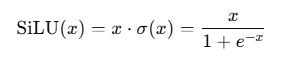

In [ ]:
# 定义 FeedForward 类，实现前馈神经网络
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, multiple_of, dropout):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = 4 * dim  # 设置隐藏层维度
            hidden_dim = int(2 * hidden_dim / 3)  # 缩小隐藏层维度为原来的2/3
            hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)  # 调整隐藏层维度为multiple_of的背书
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)  # 初始化第一层线性变换
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)  # 初始化第二层线性变换
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)  # 初始化第三层线性变换
        self.dropout = nn.Dropout(dropout)  # 初始化 dropout

    def forward(self, x):
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))  # 前向传播

## MoE专家混合门控机制

In [ ]:
# 定义 MoEGate 类，实现专家混合（MoE）的门控机制
class MoEGate(nn.Module):
    def __init__(self, config: LMConfig):
        super().__init__()
        self.config = config
        self.top_k = config.num_experts_per_tok  # 设置每个 token 选择的专家数量
        self.n_routed_experts = config.n_routed_experts  # 设置路由专家的数量

        self.scoring_func = config.scoring_func  # 设置评分函数
        self.alpha = config.aux_loss_alpha  # 设置辅助损失的权重
        self.seq_aux = config.seq_aux  # 设置序列辅助损失

        self.norm_topk_prob = config.norm_topk_prob  # 设置是否归一化 top-k 概率
        self.gating_dim = config.dim  # 设置门控维度
        self.weight = nn.Parameter(torch.empty((self.n_routed_experts, self.gating_dim)))  # 初始化权重参数
        self.reset_parameters()  # 重置参数

    def reset_parameters(self):
        import torch.nn.init as init
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))  # 使用 Kaiming 均匀初始化权重

    def forward(self, hidden_states):
        batch_size, seq_len, hidden_size = hidden_states.shape

        hidden_states = hidden_states.view(-1, hidden_size)  # 调整隐藏状态的形状
        logits = F.linear(hidden_states, self.weight, None)  # 计算 logits
        if self.scoring_func == 'softmax':
            scores = logits.softmax(dim=-1)  # 计算 softmax 评分
        else:
            raise NotImplementedError(f'不支持的MoE门控打分函数: {self.scoring_func}')

        topk_weight, topk_idx = torch.topk(scores, k=self.top_k, dim=-1, sorted=False)  # 选择 top-k 专家

        if self.top_k > 1 and self.norm_topk_prob:
            denominator = topk_weight.sum(dim=-1, keepdim=True) + 1e-20  # 计算归一化分母
            topk_weight = topk_weight / denominator  # 归一化 top-k 概率

        if self.training and self.alpha > 0.0:
            # 如果模型处于训练模式并且 self.alpha（用于控制辅助损失的权重）大于0，则计算辅助损失
            scores_for_aux = scores  # 保存当前分数（分配给各专家的概率）用于辅助损失计算
            aux_topk = self.top_k  # top_k 表示选择的 top-k 个专家数
            topk_idx_for_aux_loss = topk_idx.view(batch_size, -1)  # 获取 top-k 专家的索引，用于辅助损失

            # 检查是否使用顺序辅助（seq_aux）模式
            if self.seq_aux:
                # 如果 seq_aux 为真，则计算顺序辅助损失
                scores_for_seq_aux = scores_for_aux.view(batch_size, seq_len, -1)  # 将 scores 重新形状化为 (batch_size, seq_len, -1)
                
                # 初始化一个全零的张量 ce，用来统计选择各专家的频率，大小为 (batch_size, n_routed_experts)
                ce = torch.zeros(batch_size, self.n_routed_experts, device=hidden_states.device)

                # 使用 scatter_add_ 将 top-k 索引的位置置 1，统计选择次数
                ce.scatter_add_(1, topk_idx_for_aux_loss,
                                torch.ones(batch_size, seq_len * aux_topk, device=hidden_states.device)) \
                    .div_(seq_len * aux_topk / self.n_routed_experts)
                # 将频率归一化，确保选择频率和为1

                # 计算辅助损失，表示选择频率与分数之间的差异，乘以 alpha 控制其影响
                aux_loss = (ce * scores_for_seq_aux.mean(dim=1)).sum(dim=1).mean() * self.alpha
            else:
                # 如果不使用 seq_aux 模式，则计算非顺序辅助损失
                mask_ce = F.one_hot(topk_idx_for_aux_loss.view(-1), num_classes=self.n_routed_experts)  # 将 top-k 索引转为 one-hot 编码
                ce = mask_ce.float().mean(0)  # 求每个专家的平均选择频率

                Pi = scores_for_aux.mean(0)  # 各专家分配概率的平均值
                fi = ce * self.n_routed_experts  # 选择频率，乘以专家数量

                # 计算辅助损失 Pi * fi，乘以 alpha 控制影响
                aux_loss = (Pi * fi).sum() * self.alpha
        else:
            # 如果不在训练模式或 alpha 为 0，则不计算辅助损失
            aux_loss = None

        # 返回 top-k 索引，权重，以及计算得到的辅助损失
        return topk_idx, topk_weight, aux_loss

## MoE Feedforward

In [ ]:
class MOEFeedForward(nn.Module):
    def __init__(self, config: LMConfig):
        super().__init__()
        
        # 初始化模型配置
        self.config = config
        
        # 定义一组专家网络 (Experts)，数量由 `config.n_routed_experts` 指定
        # 每个专家是一个 FeedForward 模块，使用相同的维度、隐藏层维度和 dropout 参数
        self.experts = nn.ModuleList([
            FeedForward(
                dim=config.dim,                 # 输入维度
                hidden_dim=config.hidden_dim,   # 隐藏层维度
                multiple_of=config.multiple_of, # 隐藏层维度的倍数
                dropout=config.dropout          # dropout 概率
            )
            for _ in range(config.n_routed_experts)  # 按指定数量创建专家
        ])

        # 初始化门控机制，用于选择最合适的专家
        self.gate = MoEGate(config)
        
        # 如果配置指定有共享专家（非稀疏化），则定义一个共享的 FeedForward 模块
        if config.n_shared_experts is not None:
            self.shared_experts = FeedForward(
                dim=config.dim,
                hidden_dim=config.hidden_dim,
                multiple_of=config.multiple_of,
                dropout=config.dropout
            )

    def forward(self, x):
        # 保留输入的副本，用于加入共享专家结果
        identity = x
        
        # 获取输入的形状信息
        orig_shape = x.shape
        bsz, seq_len, _ = x.shape

        # 使用门控机制，根据输入 `x` 选择专家并计算相应的权重和辅助损失
        topk_idx, topk_weight, aux_loss = self.gate(x)

        # 将输入 `x` 展平为二维张量以便传入专家网络中
        x = x.view(-1, x.shape[-1])
        
        # 将专家索引张量展平，方便后续进行索引操作
        flat_topk_idx = topk_idx.view(-1)

        if self.training:
            # 在训练模式下，每个 token 重复 `num_experts_per_tok` 次，以便并行处理
            x = x.repeat_interleave(self.config.num_experts_per_tok, dim=0)
            
            # 初始化一个张量 `y`，用于存放专家输出，数据类型为 `float16`
            y = torch.empty_like(x, dtype=torch.float16)
            
            # 根据门控机制的索引，将输入 `x` 路由到相应的专家进行前向传播
            for i, expert in enumerate(self.experts):
                y[flat_topk_idx == i] = expert(x[flat_topk_idx == i])
            
            # 使用权重加权专家输出，并在专家维度上求和
            y = (y.view(*topk_weight.shape, -1) * topk_weight.unsqueeze(-1)).sum(dim=1)
            
            # 恢复原始输入的形状
            y = y.view(*orig_shape)
        else:
            # 在推理模式下，调用 `moe_infer` 方法直接处理专家的选择和输出
            y = self.moe_infer(x, flat_topk_idx, topk_weight.view(-1, 1)).view(*orig_shape)

        # 如果配置中指定了共享专家，则将共享专家的输出加到结果中
        if self.config.n_shared_experts is not None:
            y = y + self.shared_experts(identity)

        return y
    
    @torch.no_grad()  # 禁用梯度计算，节省内存和计算资源，在推理过程中不需要反向传播
    def moe_infer(self, x, flat_expert_indices, flat_expert_weights):
        # 创建一个与输入x形状相同的张量，初始化为零，用于存储每个专家的输出结果
        expert_cache = torch.zeros_like(x)
        
        # 对flat_expert_indices进行排序，获得排序后的索引
        idxs = flat_expert_indices.argsort()

        # 计算每个专家处理的token数量，并得到每个专家的token索引的累计和
        tokens_per_expert = flat_expert_indices.bincount().cpu().numpy().cumsum(0)
        
        # 根据排序后的索引，计算每个token对应的专家的索引
        token_idxs = idxs // self.config.num_experts_per_tok  # token所属的专家索引
        
        # 例如当tokens_per_expert=[6, 15, 20, 26, 33, 38, 46, 52]时，
        # token_idxs对应的值会像 [3, 7, 19, 21, 24, 25,  4,  5,  6, 10, 11, 12, ...]，
        # 意味着当token_idxs[:6] -> [3, 7, 19, 21, 24, 25, 4]的token由专家0处理，
        # token_idxs[6:15] -> [11, 16, 17, 20, 22, 23,  9, 10, 15]的token由专家1处理，依此类推。

        # 遍历每个专家的token范围
        for i, end_idx in enumerate(tokens_per_expert):
            # 获取当前专家处理的token的起始索引和结束索引
            start_idx = 0 if i == 0 else tokens_per_expert[i - 1]
            
            # 如果当前专家没有token需要处理，跳过当前循环
            if start_idx == end_idx:
                continue
            
            # 获取当前专家的模型
            expert = self.experts[i]
            
            # 从token_idxs中获取当前专家需要处理的token索引
            exp_token_idx = token_idxs[start_idx:end_idx]
            
            # 根据token索引从输入x中提取出对应的tokens
            expert_tokens = x[exp_token_idx]
            
            # 将当前专家的模型应用于该token集合，得到当前专家的输出
            expert_out = expert(expert_tokens)
            
            # 根据权重对当前专家的输出进行加权
            expert_out.mul_(flat_expert_weights[idxs[start_idx:end_idx]])

            # 使用scatter_add_对专家的输出进行汇总
            # 通过exp_token_idx索引将专家的输出分配到expert_cache中
            expert_cache.scatter_add_(0, exp_token_idx.view(-1, 1).repeat(1, x.shape[-1]), expert_out)

        # 返回汇总后的专家输出结果
        return expert_cache

## Transformer block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, layer_id, args):
        super().__init__()
        self.n_heads = args.n_heads # 头数
        self.dim = args.dim # 嵌入层向量维度
        self.head_dim = args.dim // args.n_heads # 注意力头维度
        self.attention = Attention(args)  # 初始化自注意力机制

        self.layer_id = layer_id # 层编号
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)  # 初始化注意力归一化
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)  # 初始化前馈神经网络归一化

        if args.use_moe:
            self.feed_forward = MOEFeedForward(args)  # 初始化专家混合前馈神经网络
        else:
            self.feed_forward = FeedForward(
                dim=args.dim,
                hidden_dim=args.hidden_dim,
                multiple_of=args.multiple_of,
                dropout=args.dropout,
            )  # 初始化前馈神经网络

    def forward(self, x, pos_cis, use_kv_cache=False):
        h = x + self.attention(self.attention_norm(x), pos_cis, use_kv_cache)  # 计算自注意力
        out = h + self.feed_forward(self.ffn_norm(h))  # 计算前馈神经网络
        return out  # 返回输出

## CFSLM整体结构

交叉熵损失函数：$Loss=-\sum_{i=1}^{C} y_i\times log(p_i)$

In [ ]:
class CFSLM(PreTrainedModel):
    config_class = LMConfig
    last_loss: Optional[torch.Tensor]

    def __init__(self, params = None):
        super().__init__(params)
        if not params:
            params = LMConfig()
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)  # 初始化词嵌入层
        self.dropout = nn.Dropout(params.dropout)  # 初始化 dropout 层
        self.transformer_blocks = torch.nn.ModuleList()  # 初始化 Transformer 块列表
        for layer_id in range(self.n_layers):
            self.transformer_blocks.append(TransformerBlock(layer_id, params))  # 添加 Transformer 块
        self.norm = RMSNorm(params.dim, eps=params.norm_eps)  # 初始化归一化层
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)  # 初始化输出层
        self.tok_embeddings.weight = self.output.weight  # 共享词嵌入和输出层的权重
        pos_cis = precompute_pos_cis(self.params.dim // self.params.n_heads, self.params.max_seq_len)  # 预计算位置编码
        self.register_buffer("pos_cis", pos_cis, persistent=False)  # 注册位置编码缓冲区

        self.apply(self._init_weights)  # 初始化模型权重

        for param_name, param_value in self.named_parameters():
            # 对模型中名为 'w3.weight' 和 'wo.weight' 的权重参数进行初始化，
            # 使用均值为0、标准差为 0.02 / math.sqrt(2 * params.n_layers) 的正态分布随机值
            if param_name.endswith('w3.weight') or param_name.endswith('wo.weight'):
                torch.nn.init.normal_(param_value, mean=0.0, std=0.02 / math.sqrt(2 * params.n_layers))

        self.last_loss = None  # 记录批次样本损失
        self.OUT = CausalLMOutputWithPast()  # 初始化输出对象

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)  # 初始化线性层的权重
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)  # 初始化线性层的偏置
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)  # 初始化嵌入层的权重

    def forward(self, tokens = None, targets = None, use_kv_cache=False, **keyargs):
        if 'input_ids' in keyargs:
            tokens = keyargs['input_ids']  # 如果传入了 input_ids，则使用 input_ids
        if 'attention_mask' in keyargs:
            targets = keyargs['attention_mask']  # 如果传入了 attention_mask，则使用 attention_mask

        bitch_size, seq_len = tokens.shape  # 获取批次大小和序列长度
        x = self.tok_embeddings(tokens)  # token向量嵌入
        x = self.dropout(x)  # 应用 dropout
        pos_cis = self.pos_cis[:seq_len]  # 根据序列长度获取旋转位置编码
        for idx, transformer_block in enumerate(self.transformer_blocks):
            x = transformer_block(x, pos_cis, use_kv_cache)  # 逐层应用 Transformer 块

        x = self.norm(x)  # 应用归一化

        if targets is not None:
            logits = self.output(x)  # 计算 logits
            self.last_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)  # 计算交叉熵损失
        else:
            logits = self.output(x[:, [-1], :])  # 计算最后一个 token 的 logits
            self.last_loss = None  # 没有目标时，损失为 None

        self.OUT.__setitem__('logits', logits)  # 设置输出对象的 logits
        self.OUT.__setitem__('last_loss', self.last_loss)  # 设置输出对象的 last_loss

        return self.OUT  # 返回输出对象

    @torch.inference_mode()  # 推理模式
    def generate(self, idx, eos, max_new_tokens, temperature=0.7, top_k=None, stream=True, repetition_penalty=1.,
                 use_kv_cache=True):
        # 生成模式
        index = idx.shape[1]  # 获取当前序列长度
        while idx.shape[1] < max_new_tokens - 1:  # 当生成的 token 数量小于最大数量时
            inference_res = self(idx, use_kv_cache=use_kv_cache)  # 进行前向传播
            logits = inference_res.logits  # 获取 logits
            logits = logits[:, -1, :]  # 获取最后一个 token 的 logits

            for token in set(idx.tolist()[0]):  # 对重复 token 进行惩罚
                logits[:, token] /= repetition_penalty

            if temperature == 0.0:  # 如果温度为 0，直接选择概率最高的 token
                _, idx_next = torch.topk(logits, k=1, dim=-1)
            else:
                logits = logits / temperature  # 调整 logits
                if top_k is not None:  # 如果设置了 top-k 采样
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = -float('Inf')  # 将小于 top-k 的 logits 设为负无穷

                probs = F.softmax(logits, dim=-1)  # 计算概率
                idx_next = torch.multinomial(probs, num_samples=1, generator=None)  # 采样下一个 token

            if idx_next == eos:  # 如果生成的 token 是结束符，停止生成
                break

            idx = torch.cat((idx, idx_next), dim=1)  # 将生成的 token 添加到序列中
            if stream:  # 如果需要流式输出
                yield idx[:, index:]  # 返回生成的 token

        if not stream:  # 如果不需要流式输出
            yield idx[:, index:]  # 返回生成的 token

    @torch.inference_mode()  # 推理模式
    def eval_answer(self, idx):
        # 问答模式
        idx_cond = idx if idx.size(1) <= self.params.max_seq_len else idx[:, -self.params.max_seq_len:]  # 截取序列
        inference_res = self(idx_cond)  # 进行前向传播
        logits = inference_res.logits  # 获取 logits
        logits = logits[:, -1, :]  # 获取最后一个 token 的 logits
        return logits  # 返回 logits